1. Скачать видео:
https://www.youtube.com/watch?v=NdSqAAT28v0

In [ ]:
import os
!yt-dlp 'https://www.youtube.com/watch?v=NdSqAAT28v0' -o 'video.webm'

2. Средствами библиотек Python извлечь из видео кадры (в оригинале извлекался каждый третий кадр).

In [74]:
import cv2

vidcap = cv2.VideoCapture('video.webm')

In [75]:
import os

os.makedirs('video_frames', exist_ok=True)

frame_margin = 3

success, image = vidcap.read()
count = 1
alt_count = 1
while success:
    if count % frame_margin == 0:
        cv2.imwrite(os.path.join("video_frames", f"image_{alt_count}.png"), image)
        alt_count += 1
    success, image = vidcap.read()
    count += 1


3. Средствами библиотек Python преобразовать разрешение кадров 1920x1080 -> 96x54 (можно другое соотношение).

In [ ]:
import cv2, os
import numpy as np

os.makedirs('video_frames_small', exist_ok=True)
kernel = np.array([[0, -1, 0],
                   [-1, 5, -1],
                   [0, -1, 0]])
for image_name in os.listdir('video_frames'):
    image = cv2.imread(os.path.join('video_frames', image_name))
    image = cv2.filter2D(image, kernel=kernel, ddepth=-5)
    image = cv2.resize(image, (96, 54))
    cv2.imwrite(os.path.join("video_frames_small", image_name), image)

4. Средствами библиотек Python перевести в черно-белое изображение (белый фон, черная фигура)

In [578]:
import cv2, os
import numpy as np

os.makedirs('video_frames_bw', exist_ok=True)
for image_name in os.listdir('video_frames_small'):
    image = cv2.imread(os.path.join('video_frames_small', image_name), 1)
    tmp = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    _, alpha = cv2.threshold(tmp, 5, 255, cv2.THRESH_BINARY)
    # image[alpha.astype(bool), :] = [255, 255, 255]
    # image[np.logical_not(alpha.astype(bool)), :] = [0, 0, 0]
    image = np.dstack((alpha, alpha, alpha))
    cv2.imwrite(os.path.join("video_frames_bw", image_name), image)

5. Обучить в Pytorch автоэнкодер (с помощью полносвязных слоев или, как в видео, сверточных) так, чтобы каждое изображение кодировалось вектором длины 128.

In [579]:
import matplotlib.pyplot as plt
import cv2
import numpy as np
import os
import keras

In [580]:
images = []
for image_name in os.listdir("video_frames_bw"):
    image_full_path = os.path.join("video_frames_bw", image_name)
    image = cv2.imread(image_full_path)[:, :, 1]
    images.append(image)
images = np.array(images)

In [695]:
from keras import layers
from keras import models
from keras import optimizers

IMAGE_SHAPE = (54, 96)


def build_autoencoder_parts(img_shape, code_size):
    # The encoder
    encoder = models.Sequential()
    encoder.add(layers.InputLayer(img_shape))
    encoder.add(layers.Flatten())
    encoder.add(layers.Normalization())
    encoder.add(layers.Dense(1024, activation='relu'))
    encoder.add(layers.Dense(512, activation='relu'))
    encoder.add(layers.Dense(code_size, activation='relu'))

    # The decoder
    decoder = models.Sequential()
    decoder.add(layers.InputLayer((code_size,)))
    decoder.add(layers.Dense(512, activation='relu'))
    decoder.add(layers.Dense(1024, activation='relu'))
    decoder.add(layers.Dense(np.prod(img_shape), activation='relu'))
    decoder.add(layers.Normalization(invert=True))
    decoder.add(layers.Reshape(img_shape))
    # # encoder
    # encoder = models.Sequential()
    # encoder.add(layers.InputLayer(img_shape))
    # encoder.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
    # encoder.add(layers.MaxPooling2D((2, 2), padding='same'))
    # 
    # # decoder
    # decoder = models.Sequential()
    # decoder.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
    # decoder.add(layers.UpSampling2D((2, 2)))
    # decoder.add(layers.Conv2D(1, (3, 3), activation='sigmoid', padding='same'))
    return encoder, decoder


def build_auto_encoder(img_shape, encoder, decoder):
    inp = layers.Input(img_shape)
    code = encoder(inp)
    reconstruction = decoder(code)

    auto_encoder = models.Model(inp, reconstruction)
    optimizer = optimizers.Adam(0.001)
    auto_encoder.compile(optimizer=optimizer, loss='mse', metrics=['accuracy'])
    return auto_encoder


encoder, decoder = build_autoencoder_parts(IMAGE_SHAPE, 128)
auto_encoder = build_auto_encoder(IMAGE_SHAPE, encoder, decoder)

In [696]:
import tensorflow as tf

def scheduler(epoch):
    if epoch <= 30:
        return 0.001
    # if epoch <= 15:
    #     return 0.0001
    # return 0.00001
    return 0.0001

lr_callback = tf.keras.callbacks.LearningRateScheduler(scheduler)

history = auto_encoder.fit(images, images, batch_size=500, epochs=200, callbacks=[lr_callback])

Epoch 1/200
96/96 ━━━━━━━━━━━━━━━━━━━━ 6s 22ms/step - accuracy: 0.0179 - loss: 31877.1445 - learning_rate: 0.0010
Epoch 2/200
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.0216 - loss: 6554.3677 - learning_rate: 0.0010
Epoch 3/200
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.0205 - loss: 5548.2378 - learning_rate: 0.0010
Epoch 4/200
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.0200 - loss: 4971.2427 - learning_rate: 0.0010
Epoch 5/200
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.0101 - loss: 4347.5098 - learning_rate: 0.0010
Epoch 6/200
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.0088 - loss: 3975.7036 - learning_rate: 0.0010
Epoch 7/200
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.0085 - loss: 3729.7322 - learning_rate: 0.0010
Epoch 8/200
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.0083 - loss: 3491.6335 - learning_rate: 0.0010
Epoch 9/200
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.0071 - loss: 3339.5701 - learning_rat

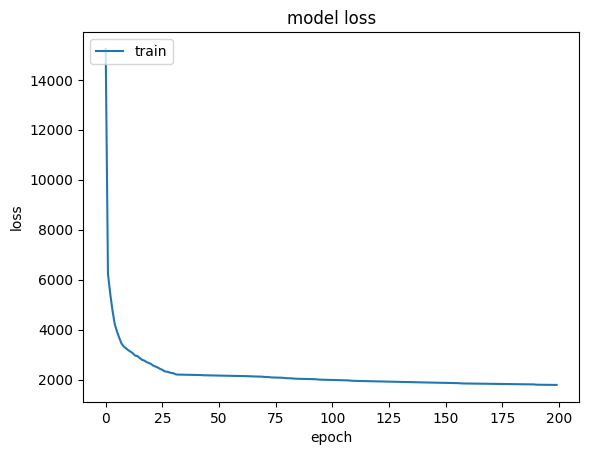

In [697]:
plt.plot(history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


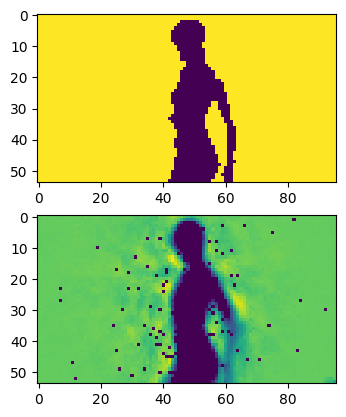

In [698]:
import matplotlib.pyplot as plt

test_image = cv2.imread('video_frames_bw/image_400.png')[:, :, 1]

plt.subplot(2, 1, 1)
plt.imshow(test_image)

predicted = auto_encoder.predict(np.array([test_image]))

plt.subplot(2, 1, 2)
plt.imshow(predicted.reshape(54, 96))


6. Перевести все изображения в последовательность 128-мерных векторов.

In [699]:
predicted = encoder.predict(np.array([test_image]))
predicted

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step


array([[   0.     ,  400.35413,    0.     ,    0.     ,  842.0465 ,
         319.06458,    0.     ,  699.56384,    0.     ,    0.     ,
         831.3955 ,    0.     ,    0.     ,  876.32947,  456.45172,
        1181.9021 ,    0.     ,    0.     ,    0.     ,    0.     ,
         784.7207 ,    0.     ,    0.     ,    0.     , 1248.0836 ,
           0.     ,  148.88873,  329.31656, 1297.2616 ,    0.     ,
           0.     , 1136.1931 ,    0.     ,    0.     ,    0.     ,
           0.     ,    0.     ,    0.     , 1323.5886 ,    0.     ,
           0.     ,    0.     ,    0.     ,    0.     ,  915.8654 ,
           0.     , 1531.5581 ,    0.     ,    0.     ,  644.3673 ,
           0.     ,    0.     ,    0.     , 1230.7684 ,    0.     ,
           0.     ,  347.14154,    0.     ,    0.     ,    0.     ,
           0.     ,    0.     ,    0.     ,    0.     ,    0.     ,
         841.8056 ,    0.     ,    0.     ,    0.     ,  701.8616 ,
           0.     ,    0.     ,  563.2733 ,  460

In [700]:
codes = encoder.predict(images)
codes

1499/1499 ━━━━━━━━━━━━━━━━━━━━ 2s 923us/step


array([[   0.      , 1158.6083  ,  970.08307 , ...,  909.3232  ,
         981.8679  ,  642.7306  ],
       [   0.      ,  826.9808  ,    0.      , ..., 1422.601   ,
         692.4364  , 1052.9347  ],
       [   0.      ,  860.21045 ,    0.      , ...,  675.79254 ,
           0.      ,  594.94446 ],
       ...,
       [   0.      ,  670.87885 ,    0.      , ..., 1011.56177 ,
          57.552036,  559.8957  ],
       [   0.      ,  812.97284 ,    0.      , ..., 1518.1141  ,
         317.91736 , 1433.2322  ],
       [   0.      ,  621.21686 ,    0.      , ..., 1085.3983  ,
           0.      ,  700.427   ]], dtype=float32)

In [701]:
np.savetxt("codes.csv", codes, delimiter=",")

In [702]:
generated_img = decoder.predict(codes)

1499/1499 ━━━━━━━━━━━━━━━━━━━━ 2s 969us/step


In [703]:
import cv2
import numpy as np
import glob
# пробуем создать видео без rnn по кодам
frameSize = (96, 54)

out = cv2.VideoWriter('decoded_video.avi', cv2.VideoWriter_fourcc(*'DIVX'), 10, frameSize)

for img in generated_img:
    img = np.dstack((img, img, img)).astype(np.uint8)
    out.write(img)

out.release()

7. Обучить рекуррентную нейронную сеть (подобрать параметры самостоятельно) предсказывать по текущему следующий вектор.

In [704]:
import matplotlib.pyplot as plt
import cv2
import numpy as np
import os

In [705]:
codes = np.genfromtxt('codes.csv', delimiter=',')

In [726]:
from keras import layers
from keras import models


def create_RNN():
    model = models.Sequential()
    model.add(layers.InputLayer((128, 1)))
    model.add(layers.SimpleRNN(128, return_sequences=True))
    model.add(layers.SimpleRNN(256, return_sequences=True))
    model.add(layers.SimpleRNN(128, return_sequences=True))
    model.add(layers.Dense(units=1, activation='linear'))
    model.compile(loss='mean_squared_error', optimizer='adamax')
    return model


rnn_model = create_RNN()

In [727]:
import tensorflow as tf


def scheduler(epoch):
    if epoch <= 15:
        return 0.001
    return 0.0001


lr_callback = tf.keras.callbacks.LearningRateScheduler(scheduler)

history = rnn_model.fit(x=codes[1:], y=codes[:-1], epochs=50, batch_size=500, callbacks=[lr_callback])

Epoch 1/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 11s 74ms/step - loss: 335788.3125 - learning_rate: 0.0010
Epoch 2/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 6s 59ms/step - loss: 327066.2812 - learning_rate: 0.0010
Epoch 3/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 5s 57ms/step - loss: 319722.3438 - learning_rate: 0.0010
Epoch 4/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 5s 55ms/step - loss: 312355.8125 - learning_rate: 0.0010
Epoch 5/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 6s 58ms/step - loss: 305198.0000 - learning_rate: 0.0010
Epoch 6/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 5s 57ms/step - loss: 298118.7188 - learning_rate: 0.0010
Epoch 7/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 6s 57ms/step - loss: 291203.6875 - learning_rate: 0.0010
Epoch 8/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 5s 57ms/step - loss: 284276.4062 - learning_rate: 0.0010
Epoch 9/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 6s 59ms/step - loss: 277583.6875 - learning_rate: 0.0010
Epoch 10/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 6s 59ms/step - loss: 270956.8125 - learning_rate: 0.0010
Epoch 11/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 6s 58ms/s

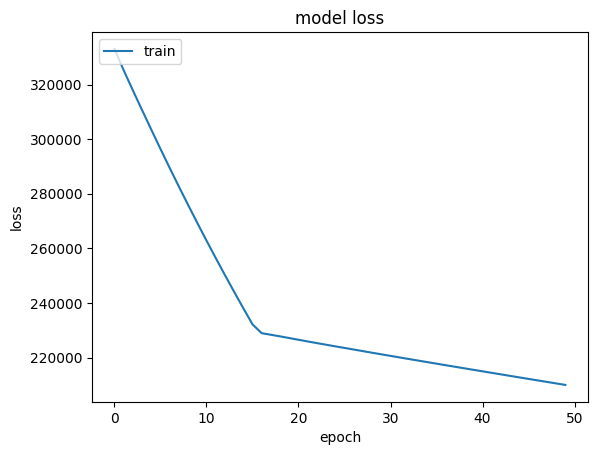

In [728]:
plt.plot(history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [729]:
predicted = rnn_model.predict(np.array([codes[123]]))
predicted.reshape(128)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 380ms/step


array([ 3.48428488e-01,  2.51976288e+02,  7.79817724e+00, -1.70002580e-01,
        2.51996719e+02,  2.51996445e+02,  5.96890807e-01,  2.51995697e+02,
       -8.93742204e-01, -1.72123551e-01,  2.51992615e+02,  1.22015512e+00,
        1.40017958e+01,  2.51996689e+02,  2.51995377e+02,  2.51992645e+02,
        3.03629255e+00,  1.08120668e+00,  1.65622079e+00, -1.23842835e-01,
        2.51996735e+02, -2.74531007e-01, -2.42125154e-01, -1.09354615e-01,
        2.51995117e+02,  2.48714590e+00,  3.81212540e+01,  2.51996765e+02,
        2.51992935e+02, -6.77191019e-02, -1.03490126e+00,  2.51995590e+02,
        1.22720122e-01,  1.34317148e+00, -4.30857301e-01,  6.10291958e-03,
       -4.53507066e-01,  3.32204223e-01,  2.51996704e+02, -2.16578913e+00,
       -1.24278319e+00, -3.73793244e-01,  3.44518423e+00,  8.09411407e-01,
        2.51996155e+02,  3.39747381e+00,  2.51996399e+02,  2.95602751e+00,
        1.22952020e+00,  2.51996765e+02,  1.62319756e+01, -2.14598298e-01,
        7.10500479e-02,  

8. С помощью обученной сети сгенерировать последовательность векторов.

In [730]:
previous = codes[4312]  # just random code
sequence = []
for i in range(1000):
    predicted = rnn_model.predict(np.array([previous]))
    previous = predicted.reshape(128)
    sequence.append(previous)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━

In [731]:
np.savetxt("sequence.csv", sequence, delimiter=",")

9. Перевести с помощью декодера последовательность векторов в последовательность кадров.

In [732]:
sequence = np.genfromtxt('sequence.csv', delimiter=',')

generated_img = decoder.predict(sequence)

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 739us/step


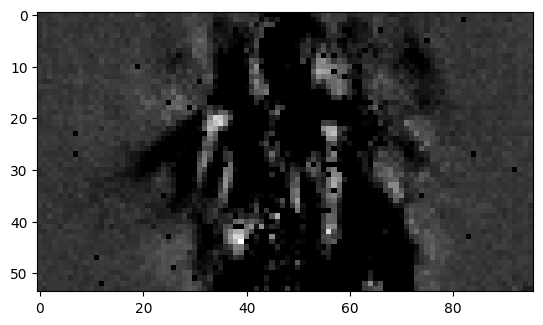

In [733]:
plt.imshow(generated_img[100], cmap="gray")

10. Средствами библиотек Python преобразовать кадры в видео.

In [734]:
generated_img.shape

(1000, 54, 96)

In [735]:
import cv2
import numpy as np
import glob

frameSize = (96, 54)

out = cv2.VideoWriter('output_video.avi', cv2.VideoWriter_fourcc(*'DIVX'), 10, frameSize)

for img in generated_img:
    img = np.dstack((img, img, img)).astype(np.uint8)
    out.write(img)

out.release()